In [124]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import argparse
from PIL import Image

from transform import build_se3_transform
from image import load_image
from camera_model import CameraModel
from build_pointcloud import build_pointcloud
from project_velodyne_into_camera import bpc

In [125]:
CROP_AREA = [0, 200, 1280, 810]

MIN_DEPTH = 1e-3
MAX_DEPTH = 80

EXTRINSICS = '/home/carlo/Documents/tesi/server/robotcar-dataset-sdk/extrinsics'
MODELS_DIR = '/home/carlo/Documents/tesi/server/robotcar-dataset-sdk/models'

# Hard coded
PREDICTIONS_DIR = '/home/carlo/Documents/datasets/oxford-radar/md2-oxford-mono-640x416/2019-01-10-14-36-48-radar-oxford-10k-partial/stereo/left'
STEREO_LEFT = '/home/carlo/Documents/datasets/oxford-radar/2019-01-10-14-36-48-radar-oxford-10k-partial/stereo/left'
VELO_L = '/home/carlo/Documents/datasets/oxford-radar/2019-01-10-14-36-48-radar-oxford-10k-partial/velodyne_left'
VELO_R = '/home/carlo/Documents/datasets/oxford-radar/2019-01-10-14-36-48-radar-oxford-10k-partial/velodyne_right'
LMS_FRONT = '/home/carlo/Documents/datasets/oxford-radar/2019-01-10-14-36-48-radar-oxford-10k-partial/lms_front'
POSES_FILE = '/home/carlo/Documents/datasets/oxford-radar/2019-01-10-14-36-48-radar-oxford-10k-partial/vo/vo.csv'
TEST_FILE = '/home/carlo/Documents/datasets/oxford-radar/oxford_radar_large_test_files.txt'
MATCH_FILE = '/home/carlo/Documents/datasets/oxford-radar/2019-01-10-14-36-48-radar-oxford-10k-partial/match.csv'
POST_PROCESSED = '/home/carlo/Documents/datasets/oxford-radar/oxford-mono-640x416_post_processed_disps_eigen_split.npy'
####

In [126]:
test_file = open(TEST_FILE, 'r')
lines = test_file.readlines()
test_file.close()

match_file = open(MATCH_FILE, 'r')
match_lines = match_file.readlines()
match_file.close()

timestamps = []

for line in lines:
    basename = os.path.basename(line.rstrip()).split('.')[0]
    for match_line in match_lines:
        match_line = match_line.rstrip().split(' ')
        if int(match_line[0]) == int(basename):
            timestamps.append(int(match_line[1]))
            
print(timestamps)

[1547131046315627, 1547131048190664, 1547131050065734, 1547131051940770, 1547131053815808, 1547131055690879, 1547131057565915, 1547131059440952, 1547131061316035, 1547131063191059, 1547131065066096, 1547131066941166, 1547131068816202, 1547131070691239, 1547131072566309, 1547131074441346, 1547131076316383, 1547131078191453, 1547131080066490, 1547131081941526, 1547131083816597, 1547131085691633, 1547131087566671, 1547131089441709, 1547131091316777, 1547131093191815, 1547131095066852, 1547131096941922]


In [127]:
timestamp = timestamps[0]

In [128]:
model = CameraModel(MODELS_DIR, STEREO_LEFT)

extrinsics_path = os.path.join(EXTRINSICS, model.camera + '.txt')
with open(extrinsics_path) as extrinsics_file:
    extrinsics = [float(x) for x in next(extrinsics_file).split(' ')]

G_camera_vehicle = build_se3_transform(extrinsics)

# VO frame and vehicle frame are the same
G_camera_posesource = G_camera_vehicle

In [129]:
# LMS
pointcloud, reflectance = build_pointcloud(LMS_FRONT, POSES_FILE, EXTRINSICS,
                                           timestamp - 1e7, timestamp + 1e7, timestamp)

pointcloud = np.dot(G_camera_posesource, pointcloud)

image_path = os.path.join(STEREO_LEFT, str(timestamp) + '.png')

image = load_image(image_path, model)

lms_uv, lms_depth = model.project(pointcloud, image.shape)

print('image shape {}, uv shape {}, len depth {}'.format(image.shape, lms_uv.shape, len(lms_depth)))

image shape (960, 1280, 3), uv shape (2, 209714), len depth 209714


In [130]:
# Velodyne
#l = []
#for f in sorted(glob.glob(VELO_L + '/*.png')):
#    l.append(int(os.path.basename(f).split('.')[0]))
# prendo la scansione velodyne successiva più vicina al frame
#n = 10000000000000000000
#for v in l:
#    if v > timestamp and v < n:
#        n = v
#print('Next timestamp{}'.format(n))
pointcloud, reflectance = bpc(lidar_dir=VELO_L, extrinsics_dir=EXTRINSICS, poses_file=POSES_FILE,
                              start_time=timestamp, end_time=timestamp+1e6, origin_time=timestamp)
pointcloud_l = np.dot(G_camera_posesource, pointcloud)
print(pointcloud_l.shape)

#r = []
#for f in sorted(glob.glob(VELO_R + '/*.png')):
#    r.append(int(os.path.basename(f).split('.')[0]))
# prendo la scansione velodyne successiva più vicina al frame
#n = 10000000000000000000
#for v in r:
#    if v > timestamp and v < n:
#        n = v
#print('Next timestamp{}'.format(n))
pointcloud, reflectance = bpc(lidar_dir=VELO_R, extrinsics_dir=EXTRINSICS, poses_file=POSES_FILE,
                              start_time=timestamp, end_time=timestamp+1e6, origin_time=timestamp)

pointcloud_r = np.dot(G_camera_posesource, pointcloud)

print(pointcloud_r.shape)

pointcloud = np.array([[0], [0], [0], [0]])
pointcloud = np.hstack([pointcloud, pointcloud_l])
pointcloud = np.hstack([pointcloud, pointcloud_r])

image_path = os.path.join(STEREO_LEFT, str(timestamp) + '.png')
image = load_image(image_path, model)

velo_uv, velo_depth = model.project(pointcloud, image.shape)

print('image shape {}, uv shape {}, len depth {}'.format(image.shape, velo_uv.shape, len(velo_depth)))

Next timestamp1547131046360493
(4, 223640)
Next timestamp1547131046328585
(4, 223848)
image shape (960, 1280, 3), uv shape (2, 234872), len depth 234872


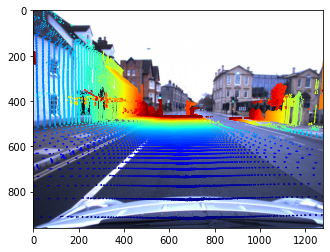

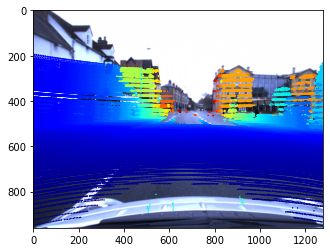

In [131]:
plt.imshow(image)
plt.scatter(np.ravel(lms_uv[0, :]), np.ravel(lms_uv[1, :]), s=2, c=lms_depth, edgecolors='none', cmap='jet')
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.show()


plt.imshow(image)
plt.scatter(np.ravel(velo_uv[0, :]), np.ravel(velo_uv[1, :]), s=2, c=velo_depth, edgecolors='none', cmap='jet')
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.show()

In [132]:
# LMS
# 0 < uv[0, :] < 1280
# 0 < uv[1, :] < 960
lms_b = []
lms_d = []
count = 0
for i in range(0, len(lms_depth)):
    if 200 < lms_uv[1, i] and lms_uv[1, i] < 810 and lms_depth[i] < 80:
        count += 1
        lms_b.append([lms_uv[0, i], lms_uv[1, i]])
        lms_d.append(lms_depth[i])
        
lms_a = np.ndarray((2, count))

for i in range(0, count):
    lms_a[0, i] = lms_b[i][0]
    lms_a[1, i] = lms_b[i][1] - 200
    
lms_img = image[200:810, :, :]
    

        
# Velo
velo_b = []
velo_d = []
count = 0
for i in range(0, len(velo_depth)):
    if 200 < velo_uv[1, i] and velo_uv[1, i] < 810 and velo_depth[i] < 80:
        count += 1
        velo_b.append([velo_uv[0, i], velo_uv[1, i]])
        velo_d.append(velo_depth[i])
        
velo_a = np.ndarray((2, count))

for i in range(0, count):
    velo_a[0, i] = velo_b[i][0]
    velo_a[1, i] = velo_b[i][1] - 200
    
velo_img = image[200:810, :, :]

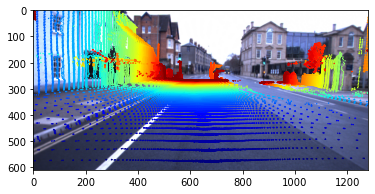

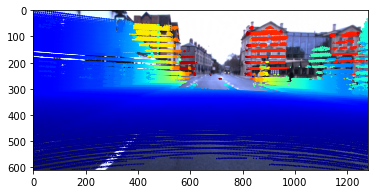

In [133]:
plt.imshow(lms_img)
plt.scatter(np.ravel(lms_a[0, :]), np.ravel(lms_a[1, :]), s=2, c=lms_d, edgecolors='none', cmap='jet')
plt.xlim(0, lms_img.shape[1])
plt.ylim(lms_img.shape[0], 0)
plt.show()

plt.imshow(velo_img)
plt.scatter(np.ravel(velo_a[0, :]), np.ravel(velo_a[1, :]), s=2, c=velo_d, edgecolors='none', cmap='jet')
plt.xlim(0, velo_img.shape[1])
plt.ylim(velo_img.shape[0], 0)
plt.show()

In [134]:
# LMS
lms_mask = np.zeros((lms_img.shape[0], lms_img.shape[1]))
print(lms_mask.shape)

for i in range(0, lms_a.shape[1]):
    if lms_mask[int(np.floor(lms_a[1, i])), int(np.floor(lms_a[0,i]))] == 0:
        lms_mask[int(np.floor(lms_a[1, i])), int(np.floor(lms_a[0,i]))] = lms_d[i]
        
    elif lms_mask[int(np.floor(lms_a[1, i])), int(np.floor(lms_a[0,i]))] > lms_d[i]:
        lms_mask[int(np.floor(lms_a[1, i])), int(np.floor(lms_a[0,i]))] = lms_d[i]

# Velo
velo_mask = np.zeros((velo_img.shape[0], velo_img.shape[1]))
print(velo_mask.shape)

for i in range(0, velo_a.shape[1]):
    if velo_mask[int(np.floor(velo_a[1, i])), int(np.floor(velo_a[0,i]))] == 0:
        velo_mask[int(np.floor(velo_a[1, i])), int(np.floor(velo_a[0,i]))] = velo_d[i]
        
    elif velo_mask[int(np.floor(velo_a[1, i])), int(np.floor(velo_a[0,i]))] > velo_d[i]:
        velo_mask[int(np.floor(velo_a[1, i])), int(np.floor(velo_a[0,i]))] = velo_d[i]

(610, 1280)
(610, 1280)


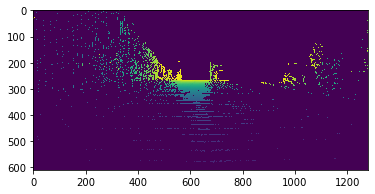

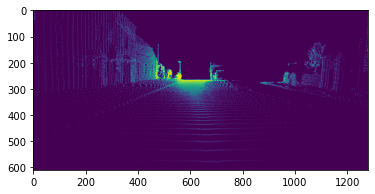

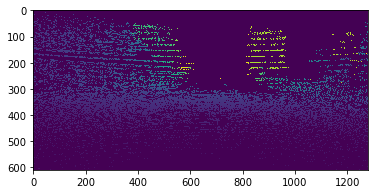

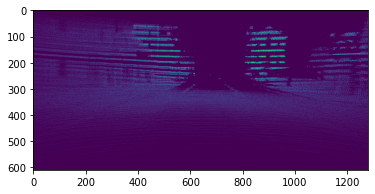

In [135]:
plt.imshow(lms_mask, interpolation='nearest')
plt.show()

plt.imshow(lms_mask)
plt.show()

plt.imshow(velo_mask, interpolation='nearest')
plt.show()

plt.imshow(velo_mask)
plt.show()

In [136]:
# CONFRONTO PIXELS TRA LMS E VELO (PRENDO I PIXEL CON VALORE > 0)
mask = np.logical_and(np.logical_and(lms_mask > MIN_DEPTH, velo_mask > MIN_DEPTH), np.logical_and(lms_mask < MAX_DEPTH, velo_mask < MAX_DEPTH))
print(np.unique(mask, return_counts=True))

(array([False,  True], dtype=bool), array([769932,  10868]))


10868
(610, 1280) (610, 1280)


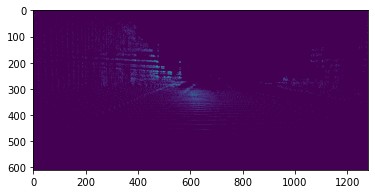

10868
(610, 1280) (610, 1280)


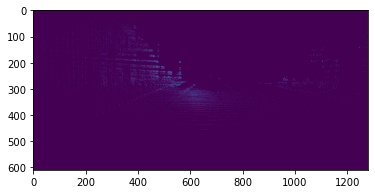

In [137]:
# LMS
lms_mk = lms_mask[mask]
print(len(lms_mk))

lms_tmp = np.zeros((lms_img.shape[0], lms_img.shape[1]))
print(lms_tmp.shape, lms_mask.shape)
for i in range(0, lms_mask.shape[0]):
    for j in range(0, lms_mask.shape[1]):
        if mask[i, j]:
            lms_tmp[i, j] = lms_mask[i, j]


plt.imshow(lms_tmp)
plt.show()            


# VELO
velo_mk = velo_mask[mask]
print(len(velo_mk))

velo_tmp = np.zeros((velo_img.shape[0], velo_img.shape[1]))
print(velo_tmp.shape, velo_mask.shape)
for i in range(0, velo_mask.shape[0]):
    for j in range(0, velo_mask.shape[1]):
        if mask[i, j]:
            velo_tmp[i, j] = velo_mask[i, j]

plt.imshow(velo_tmp)
plt.show()     

In [138]:
# DISTANCE METRICS
def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))

    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

In [140]:
errors = []
errors.append(compute_errors(lms_mk, velo_mk))
mean_errors = np.array(errors).mean(0)
print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")

errors = []
errors.append(compute_errors(velo_mk, lms_mk))
mean_errors = np.array(errors).mean(0)
print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")


   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.054  &   0.431  &   3.662  &   0.104  &   0.963  &   0.987  &   0.996  \\

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.050  &   0.340  &   3.662  &   0.104  &   0.963  &   0.987  &   0.996  \\


In [141]:
errors = []
errors.append(compute_errors(lms_mk, velo_mk))
errors.append(compute_errors(velo_mk, lms_mk))
mean_errors = np.array(errors).mean(0)
print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")


   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.052  &   0.385  &   3.662  &   0.104  &   0.963  &   0.987  &   0.996  \\
